# 🧬 Fine-Tuning a Pre-Trained Model on BigWig Tracks Prediction

This notebook demonstrates a **simplified fine-tuning setup** that enables training of a **pre-trained Nucleotide Transformer v3 (NTv3) model** to predict BigWig signal tracks directly from DNA sequences. The streamlined approach leverages a pre-trained NTv3 backbone as a feature extractor and adds a custom prediction head that outputs single-nucleotide resolution signal values for various genomic tracks (e.g., ChIP-seq, ATAC-seq, RNA-seq).

📊 We provide access to the NTv3-benchmark data that we released on our Hugging Face dataset: `InstaDeepAI/NTv3_benchmark_dataset`. In this repository, you will find ready-to-use genome FASTA files, Bigwig tracks, metadata, but also the splits that were used for the benchmark.

**🔧 Main Simplifications**: Compared to the full supervised tracks pipeline used in the paper, this notebook simplifies several aspects to enable faster experimentation with limited resources for users:
- **Constant learning rate**: Uses a fixed learning rate throughout training without learning rate scheduling
- **No gradient accumulation**: Implements simple step-based training without gradient accumulation, making the training loop more straightforward but changing the effective batch size compared with the full pipeline

**⚡ Key Advantage**: This simplified pipeline achieves close performance to more complex training approaches while enabling fast fine-tuning: on a H100 GPU and using 16 workers for data loading, it takes ~15min to reach acceptable performances for a 32kb functional tracks prediction task on **NTv3_8M_pre** model. The training speed benefits from the efficient NTv3 model architecture, but of course depends on your hardware capabilities (GPU acceleration and multi-worker data loading significantly reduce training time).

## 💻 A note on hardware

While this pipeline is designed to run on limited resources (e.g., Google Colab with a T4 GPU and 2CPUs), the mentioned training time or displayed performances (see **Test evaluation** section) was obtained on a more powerful setup and is shown just as a reference. If you want to reach similar performance levels or the ones reported in the paper, you should be aware that you'll need **significant hardware resources** (high-end GPUs with substantial memory and multiple data loading workers). Training times will vary significantly based on your hardware configuration.

📝 Note for Google Colab users: This notebook is compatible with Colab and designed to work with limited resources! For faster training, make sure to enable GPU: Runtime → Change runtime type → GPU (T4 or better recommended).

# 0. 📦 Imports dependencies

In [ ]:
# Login to HuggingFace (required for gated models)
from huggingface_hub import login
login()

In [ ]:
# Install dependencies
!pip install pyfaidx pyBigWig torchmetrics transformers

In [ ]:
import functools
import fnmatch
import os
import random
from pathlib import Path
from typing import Callable, Dict, List

from huggingface_hub import HfApi, snapshot_download
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyBigWig
from pyfaidx import Fasta
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from torchmetrics import PearsonCorrCoef
from transformers import AutoConfig, AutoModelForMaskedLM, AutoTokenizer
from tqdm.auto import tqdm

# 1. ⚙️ Configuration

⏳ The parameters below are pre-configured to enable training on a T4 GPU (free on Colab). For faster training, use a more powerful GPU and increase the `batch_size`, `learning_rate`, and `num_steps_training` parameters. To speed up dataloading, consider increasing the `num_workers` value if memory and CPU resources allow.
  
🕰️ Current configuration allow to reach decent performances and completes training in ~1h30 on a colab environment with one T4 GPU and 2CPUs. 

## Configuration Parameters

### Model
- **`model_name`**: HuggingFace model name/identifier for the pretrained backbone model

### Data
- **`hf_repo_id`**: HuggingFace dataset repository ID containing the benchmark data
- **`species`**: Species name (e.g., "human") to select data from the benchmark dataset
- **`data_cache_dir`**: Directory where downloaded data files (FASTA, bigWig) will be stored
- **`sequence_length`**: Length of input sequences in base pairs (bp)
- **`keep_target_center_fraction`**: Fraction of center sequence to keep for target prediction (crops edges to focus on center)

### Training
- **`batch_size`**: Number of samples per batch
- **`learning_rate`**: Constant learning rate for optimizer
- **`weight_decay`**: L2 regularization coefficient for optimizer
- **`num_steps_training`**: Total number of training steps
- **`log_every_n_steps`**: Log training metrics every N steps

### Validation
- **`validate_every_n_steps`**: Run validation every N steps
- **`num_validation_samples`**: Number of samples to use for validation set

### Test
- **`num_test_samples`**: Number of samples to use for test set evaluation

### General
- **`seed`**: Random seed for reproducibility
- **`device`**: Device to run training on ("cuda" or "cpu")
- **`num_workers`**: Number of worker processes for DataLoader (0 = single-threaded)

In [ ]:
config = {
    # Model
    "model_name": "InstaDeepAI/NTv3_8M_pre",
    
    # Data
    "hf_repo_id": "InstaDeepAI/NTv3_benchmark_dataset",
    "species": "human",
    "data_cache_dir": "./data",
    "sequence_length": 32_768,
    "keep_target_center_fraction": 0.375,
    "bigwig_file_ids": None,  # If None, will use all available tracks for selected species
    
    # Training
    "batch_size": 8,
    "num_steps_training": 2000,  # Consider increasing for improving training performance
    "log_every_n_steps": 50,
    "learning_rate": 1e-5,
    "weight_decay": 0.01,
    
    # Validation
    "validate_every_n_steps": 100,
    "num_validation_samples": 1_000,

    # Test
    "num_test_samples": 10_000,
    
    # General
    "seed": 0,  # for reproducibility
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_workers": 2,  # If resources allows it, consider increasing for faster data loading
}

# Set random seed
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Set device
device = torch.device(config["device"])
print(f"Using device: {device}")

Using device: cuda


# 2. 📥 Genome & Tracks Data Download

Download all needed data for fine-tuning from our Hugging Face NTv3 benchmark dataset for the selected species.

These files contain:
- genomic sequences 
- experimental signal data (e.g., ChIP-seq, ATAC-seq)
- ready-to-use splits (as bed files)
- metadata for data normalization

If you want to fine-tune a model a species that is not available on our Hugging Face dataset or on other bigwig tracks, you should consider downloading the genome FASTA file and/or the BigWig files from URLs, using `wget`.

In [ ]:
def prepare_genomics_inputs(
    species: str,
    data_cache_dir: str | Path = "data",
    hf_repo_id: str = "InstaDeepAI/NTv3_benchmark_dataset",
    bigwig_file_ids: list[str] | None = None,
) -> tuple[str, list[str], list[str], pd.DataFrame, pd.DataFrame]:
    """
    Downloads:
      1) FASTA from HF dataset under: <species>/genome.fasta
      2) BigWigs from HF dataset under: <species>/functional_tracks/**
         (filtered by bigwig_file_ids if provided)
      3) Splits from HF dataset under: <species>/splits.bed
      4) Metadata from HF dataset under: benchmark_metadata.tsv
    
    Args:
        species: Species name (e.g., "human", "arabidopsis")
        data_cache_dir: Directory where downloaded data files will be stored
        hf_repo_id: HuggingFace dataset repository ID
        bigwig_file_ids: Optional list of BigWig file IDs to download. If None,
            downloads all available BigWig files for the species.
    
    Returns:
      (fasta_path, bigwig_path_list, bigwig_file_ids)
    """
    cache = Path(data_cache_dir).expanduser().resolve()
    cache.mkdir(parents=True, exist_ok=True)
    
    # --- Download metadata + <species> files (FASTA, BigWigs, Splits) ---
    metadata_file = "benchmark_metadata.tsv"
    download_patterns = [metadata_file, f"{species}/genome.fasta", f"{species}/splits.bed"]
    
    if bigwig_file_ids is not None:
        # List files to validate requested BigWig files exist
        api = HfApi()
        files = api.list_repo_files(repo_id=hf_repo_id, repo_type="dataset")
        species_pattern = f"{species}/**"
        species_files = [p for p in files if fnmatch.fnmatch(p, species_pattern)]
        
        # Get all available BigWig file IDs and their paths
        available_bigwig_files = {
            Path(p).stem: p for p in species_files 
            if Path(p).suffix == ".bigwig"
        }
        
        # Check that all requested files exist
        missing_files = set(bigwig_file_ids) - set(available_bigwig_files.keys())
        if missing_files:
            raise ValueError(
                f"Requested BigWig files not found: {missing_files}. "
                f"Available files: {list(available_bigwig_files.keys())}"
            )
        
        # Add specific patterns for requested BigWig files only
        for file_id in bigwig_file_ids:
            download_patterns.append(available_bigwig_files[file_id])
    else:
        # Download all BigWig files
        download_patterns.append(f"{species}/functional_tracks/*.bigwig")
    local_dir = Path(
        snapshot_download(
            repo_id=hf_repo_id,
            repo_type="dataset",
            allow_patterns=download_patterns,
            local_dir=str(cache),
        )
    )
    
    # --- Organize outputs ---
    # FASTA file
    fasta_path_repo = f"{species}/genome.fasta"
    fasta_path = str(local_dir / fasta_path_repo)
    
    # BigWig files - use downloaded files directly
    bigwig_dir = local_dir / species / "functional_tracks"
    
    if bigwig_file_ids is not None:
        bigwig_paths = [str(bigwig_dir / f"{file_id}.bigwig") for file_id in bigwig_file_ids]
        bigwig_ids = bigwig_file_ids
    else:
        # Find all downloaded BigWig files
        bigwig_paths = [str(bigwig_file) for bigwig_file in bigwig_dir.glob("*.bigwig")]
        bigwig_ids = [bigwig_file.stem for bigwig_file in bigwig_dir.glob("*.bigwig")]         
    
    # Splits file
    splits_path_repo = f"{species}/splits.bed"
    splits_path = local_dir / splits_path_repo

    splits_df = pd.read_csv(
        splits_path, 
        sep="\t", 
        header=None, 
        names=["chr_name", "start", "end", "split"],
        dtype={"chr_name": str, "start": int, "end": int, "split": str},
    )
    
    # Metadata file
    metadata_path = local_dir / metadata_file
    metadata_df = pd.read_csv(metadata_path, sep="\t")

    # Filter metadata according to species
    metadata_df = metadata_df[metadata_df["species_common_name"] == species].reset_index(drop=True)

    # Order metadata according to bigwig file ids
    metadata_df = (
      metadata_df.set_index("file_id")
        .loc[bigwig_ids]
        .reset_index()
    )

    return fasta_path, bigwig_paths, bigwig_ids, splits_df, metadata_df

In [4]:
os.makedirs(config["data_cache_dir"], exist_ok=True)

# Download all requested species-related files + load the splits, and metadata
(
    fasta_path, 
    bigwig_paths, 
    bigwig_ids, 
    species_splits_df,
    metadata_df 
) = prepare_genomics_inputs(
    config["species"], 
    config["data_cache_dir"], 
    config["hf_repo_id"],
    bigwig_file_ids=config["bigwig_file_ids"]
)

Fetching 37 files:   0%|          | 0/37 [00:00<?, ?it/s]

# 3. 🧠 Model and tokenizer setup
 
This section sets up the model by extended any pretrained backbone from HuggingFace Transformers (for example, `InstaDeepAI/ntv3_650M_pre`) with a custom linear head.
This linear head is trained for regression on a set of genomic tracks, allowing the model to make predictions for each track at single nucleotide resolution.
Predictions are center-cropped to focus on the central portion of the input sequence (configurable via `keep_target_center_fraction`), which helps reduce edge effects from sequence context windows.


In [ ]:
def crop_center(x: np.ndarray, keep_target_center_fraction: float = 0.375) -> np.ndarray:
    """Crop the central sequence-length fraction for arrays of size (..., seq_len, num_tracks)"""
    seq_len = x.shape[-2]
    target_offset = int(seq_len * (1 - keep_target_center_fraction) // 2)
    target_length = seq_len - 2 * target_offset
    return x[..., target_offset:target_offset + target_length, :]

class LinearHead(nn.Module):
    """A linear head that predicts one scalar value per track."""
    def __init__(self, embed_dim: int, num_labels: int):
        super().__init__()
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_labels)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer_norm(x)
        x = self.head(x)
        x = F.softplus(x)  # Ensure positive values
        return x


class HFModelWithHead(nn.Module):
    """Simple model wrapper: HF backbone + bigwig head."""
    
    def __init__(
        self,
        model_name: str,
        bigwig_track_names: List[str],
        keep_target_center_fraction: float = 0.375,
    ):
        super().__init__()
        
        # Load config and model
        self.config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
        backbone = AutoModelForMaskedLM.from_pretrained(
            model_name, 
            trust_remote_code=True,
            config=self.config,
        )
        self.backbone = torch.compile(backbone)
        
        self.keep_target_center_fraction = keep_target_center_fraction
        embed_dim = self.config.embed_dim
        
        # Bigwig head (NTv3 outputs at single-nucleotide resolution)
        self.bigwig_head = LinearHead(embed_dim, len(bigwig_track_names))
        self.model_name = model_name
    
    def forward(self, tokens: torch.Tensor, **kwargs) -> Dict[str, torch.Tensor]:
        # Forward through backbone
        outputs = self.backbone(input_ids=tokens, output_hidden_states=True)
        embedding = outputs.hidden_states[-1]  # Last hidden state
        
        # Crop to center fraction
        if self.keep_target_center_fraction < 1.0:
            embedding = crop_center(embedding, self.keep_target_center_fraction)
        
        # Predict bigwig tracks
        bigwig_logits = self.bigwig_head(embedding)
        
        return {"bigwig_tracks_logits": bigwig_logits}

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(config["model_name"], trust_remote_code=True)

# Create model
model = HFModelWithHead(
    model_name=config["model_name"],
    bigwig_track_names=bigwig_ids,
    keep_target_center_fraction=config["keep_target_center_fraction"],
)
model = model.to(device)

print(f"Model loaded: {config['model_name']}")
print(f"Number of bigwig tracks: {len(bigwig_ids)}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model loaded: InstaDeepAI/NTv3_8M_pre
Number of bigwig tracks: 34
Model parameters: 7,701,725


# 4. 🔄 Data loading

Create PyTorch datasets and data loaders that efficiently sample random genomic windows from the reference genome and extract corresponding BigWig signal values. The dataset handles sequence tokenization, target scaling, and chromosome-based train/val/test splits.

### Dataset Setup

In [ ]:
# Process-local cache for file handles (one per worker process)
# This allows safe multi-worker DataLoader usage
_fasta_cache = {}  # Maps (process_id, file_path) -> Fasta handle
_bigwig_cache = {}  # Maps (process_id, file_path) -> pyBigWig handle


def _get_fasta_handle(fasta_path: str) -> Fasta:
    """Get or create a FASTA file handle for the current process."""
    process_id = os.getpid()
    abs_path = str(Path(fasta_path).resolve())
    cache_key = (process_id, abs_path)
    
    if cache_key not in _fasta_cache:
        _fasta_cache[cache_key] = Fasta(abs_path, as_raw=True, sequence_always_upper=True)
    
    return _fasta_cache[cache_key]


def _get_bigwig_handle(bigwig_path: str) -> pyBigWig.pyBigWig:
    """Get or create a BigWig file handle for the current process."""
    process_id = os.getpid()
    abs_path = str(Path(bigwig_path).resolve())
    cache_key = (process_id, abs_path)
    
    if cache_key not in _bigwig_cache:
        # Check if file exists before trying to open
        if not Path(abs_path).exists():
            raise FileNotFoundError(
                f"BigWig file not found: {abs_path}\n"
                f"Original path: {bigwig_path}\n"
                f"Current working directory: {os.getcwd()}"
            )
        
        try:
            _bigwig_cache[cache_key] = pyBigWig.open(abs_path)
        except Exception as e:
            raise RuntimeError(
                f"Failed to open BigWig file: {abs_path} with error: {str(e)}\n"
                f"File exists: {Path(abs_path).exists()}\n"
                f"File size: {Path(abs_path).stat().st_size if Path(abs_path).exists() else 'N/A'} bytes"
            ) from e
    
    return _bigwig_cache[cache_key]


class GenomeBigWigDataset(Dataset):
    """
    A PyTorch dataset to access a reference genome and bigwig tracks. The dataset is 
    compatible with multi-worker DataLoaders (using process-local file handles and lazy 
    loading). For each sample, a random genomic region is picked from the specified split,
    and a random window of length `sequence_length` within that region is returned.
    """

    def __init__(
        self,
        fasta_path: str,
        bigwig_path_list: list[str],
        chrom_regions: pd.DataFrame,
        split: str,
        sequence_length: int,
        num_samples: int,
        tokenizer: AutoTokenizer,
        transform_fn: Callable[[torch.Tensor], torch.Tensor],
        keep_target_center_fraction: float = 1.0,
    ):
        super().__init__()

        # Store paths instead of opening files immediately (for multi-worker compatibility)
        self.fasta_path = fasta_path
        self.bigwig_path_list = bigwig_path_list
        self.sequence_length = sequence_length
        self.num_samples = num_samples
        self.tokenizer = tokenizer
        self.transform_fn = transform_fn
        self.keep_target_center_fraction = keep_target_center_fraction
        self.chrom_regions = chrom_regions

        # Filter regions by split
        split_regions = self.chrom_regions[self.chrom_regions["split"] == split].copy()

        # Filter valid regions (must be large enough for sequence_length)
        self.valid_regions = []
        for _, row in split_regions.iterrows():

            region_length = row.end - row.start
            if region_length < self.sequence_length:
                continue
            
            # Store valid region
            self.valid_regions.append((row.chr_name, row.start, row.end))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Sample a random region from the valid regions
        chrom, region_start, region_end = random.choice(self.valid_regions)
        
        # Sample a random window within this region
        max_start = region_end - self.sequence_length
        start = random.randint(region_start, max_start)
        end = start + self.sequence_length

        # Sequence - get FASTA handle lazily (cached per worker process)
        fasta = _get_fasta_handle(self.fasta_path)
        seq = fasta[chrom][start:end]  # string slice
        # Tokenize with padding and truncation to ensure consistent lengths for batching
        tokenized = self.tokenizer(
            seq,
            padding="max_length",
            truncation=True,
            max_length=self.sequence_length,
            return_tensors="pt",
        )
        tokens = tokenized["input_ids"][0]  # Shape: (max_length,)

        # Signal from bigWig tracks (numpy array) -> torch tensor
        # Get BigWig handles lazily (cached per worker process)
        bigwig_targets = np.array([
            _get_bigwig_handle(bw_path).values(chrom, start, end, numpy=True)
            for bw_path in self.bigwig_path_list
        ])  # shape (num_tracks, seq_len)
        # Transpose to (seq_len, num_tracks)
        bigwig_targets = bigwig_targets.T
        # pyBigWig returns NaN where no data; turn NaN into 0
        bigwig_targets = torch.tensor(bigwig_targets, dtype=torch.float32)
        bigwig_targets = torch.nan_to_num(bigwig_targets, nan=0.0)
        
        # Crop targets to center fraction
        if self.keep_target_center_fraction < 1.0:
            bigwig_targets = crop_center(bigwig_targets, self.keep_target_center_fraction)

        # Apply scaling to targets
        bigwig_targets = self.transform_fn(bigwig_targets)

        sample = {
            "tokens": tokens,
            "bigwig_targets": bigwig_targets,
            "chrom": chrom,
            "start": start,
            "end": end,
        }
        return sample

### Scaling function Setup

In [ ]:
def create_targets_scaling_fn(
    metadata_df: pd.DataFrame
) -> Callable[[torch.Tensor], torch.Tensor]:
    """
    Build a scaling function that uses the track means to normalise and softclip the targets.
    """
    # Open bigwig files and compute track statistics
    track_means = metadata_df["mean"].to_numpy()
    print(f"Track means: {track_means}")
    print(f"Number of tracks: {track_means.shape}")

    # Create tensor from computed means
    track_means_tensor = torch.tensor(track_means, dtype=torch.float32)

    def transform_fn(x: torch.Tensor) -> torch.Tensor:
        # Move constants to correct device then normalize
        means = track_means_tensor.to(x.device)
        scaled = x / means

        # Smooth clipping: if > 10, apply formula
        clipped = torch.where(
            scaled > 10.0,
            2.0 * torch.sqrt(scaled * 10.0) - 10.0,
            scaled,
        )
        return clipped

    return transform_fn

### Instantiate datasets and dataloaders

In [23]:
# Create datasets & dataloaders
create_dataset_fn = functools.partial(
    GenomeBigWigDataset,
    fasta_path=fasta_path,
    bigwig_path_list=bigwig_paths,
    chrom_regions=species_splits_df,
    sequence_length=config["sequence_length"],
    tokenizer=tokenizer,
    transform_fn=create_targets_scaling_fn(metadata_df),
    keep_target_center_fraction=config["keep_target_center_fraction"],
)

train_dataset = create_dataset_fn(
    split="train",
    num_samples=config["num_steps_training"] * config["batch_size"],
)

val_dataset = create_dataset_fn(
    split="val",
    num_samples=config["num_validation_samples"],
)

test_dataset = create_dataset_fn(
    split="test",
    num_samples=config["num_test_samples"],
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=config["num_workers"],
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=config["num_workers"],
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=config["num_workers"],
)

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Track means: [0.72501702 0.0034627  0.00400846 0.00877379 0.01080696 0.00211876
 0.66685837 0.00370035 0.44757743 0.00627039 0.01177604 0.00530738
 0.64354244 0.63734638 0.65863696 0.74402866 0.00494403 0.01612531
 0.00498001 0.0057952  0.01549048 0.00335876 0.48636405 0.00820212
 0.72625355 0.00574464 0.00343102 0.00219467 0.00622468 0.00376132
 0.00128605 0.0463601  0.00548278 0.00227474]
Number of tracks: (34,)

Train samples: 96000
Val samples: 1000
Test samples: 10000


# 5. ⚙️ Optimizer setup

Configure the AdamW optimizer with learning rate and weight decay hyperparameters. This optimizer will update the model parameters during training to minimize the loss function.



In [24]:
# Training setup
print(f"Training configuration:")
print(f"  Batch size: {config['batch_size']}")
print(f"  Total training steps: {config['num_steps_training']}")
print(f"  Log metrics every: {config['log_every_n_steps']} steps")
print(f"  Validate every: {config['validate_every_n_steps']} steps")

# Setup optimizer
optimizer = AdamW(
    model.parameters(),
    lr=config["learning_rate"],
    weight_decay=config["weight_decay"],
)

print(f"\nOptimizer setup:")
print(f"  Learning rate: {config['learning_rate']}")

Training configuration:
  Batch size: 32
  Total training steps: 3000
  Log metrics every: 50 steps
  Validate every: 100 steps

Optimizer setup:
  Learning rate: 5e-05


# 6. 📊 Metrics setup

Set up evaluation metrics to track model performance during training and validation. We use Pearson correlation coefficients to measure how well the predicted BigWig signals match the ground truth signals.

In [ ]:
class TracksMetrics:
    """Metrics to handle multi-track pearson correlations and losses"""
    
    def __init__(self, track_names: List[str], split: str):
        self.track_names = track_names
        self.num_tracks = len(track_names)
        self.split = split

        # Initialise metrics 
        self.pearson = PearsonCorrCoef(num_outputs=self.num_tracks).to(device)
        self.pearson.set_dtype(torch.float64) # Use float64 for improved numerical stability
        self.losses = []

        # Record mean metrics per logging interval
        self.step_idxs = []
        self.mean_pearsons = []
        self.mean_losses = []
    
    def reset(self):
        self.pearson.reset()
        self.losses = []
    
    def update(
        self, 
        predictions: torch.Tensor, 
        targets: torch.Tensor,
        loss: float
    ):
        """
        Update the metrics with predictions and targets of shape (..., num_tracks) and a scalar loss.
        """
        # Flatten batch and sequence dimensions
        pred_flat = predictions.detach().reshape(-1, self.num_tracks).to(torch.float64)  # (N, num_tracks)
        target_flat = targets.detach().reshape(-1, self.num_tracks).to(torch.float64)  # (N, num_tracks)
        
        # Update metrics
        self.pearson.update(pred_flat, target_flat)
        self.losses.append(loss)
    
    def compute(self) -> Dict[str, float]:
        """Compute the pearson correlations and loss and return a dictionary of metrics."""
        # Per-track Pearson correlations
        correlations = self.pearson.compute().cpu().numpy()
        metrics_dict = {
            f"{track_name}/pearson": correlations[i] for i, track_name in enumerate(self.track_names)
        }
        metrics_dict["mean/pearson"] = correlations.mean()
        
        # Mean loss
        metrics_dict["loss"] = np.mean(self.losses)
        
        return metrics_dict

    def update_mean_metrics(self, step_idx: int):
        """Update the mean metrics over the logging interval and save to a csv file."""
        # Update mean metrics with the mean pearson & average loss
        metrics_dict = self.compute()
        self.step_idxs.append(step_idx)
        self.mean_pearsons.append(metrics_dict["mean/pearson"])
        self.mean_losses.append(metrics_dict["loss"])

        # Save metrics to a csv for plotting
        data = {
            "step": self.step_idxs,
            "mean_loss": self.mean_losses,
            "mean_pearson": self.mean_pearsons,
        }
        df = pd.DataFrame(data)
        df.to_csv(f"metrics_{self.split}.csv", index=False)
        
    def print_metrics(self, print_per_track: bool = False):
        """Print a summary of the metrics."""
        print(
            f"Step {self.step_idxs[-1]}/{config['num_steps_training']} | "
            f"Loss: {self.mean_losses[-1]:.4f} | "
            f"Mean Pearson: {self.mean_pearsons[-1]:.4f}"
        )
        metrics_dict = self.compute()
        if print_per_track:
            for metric_key, metric_value in metrics_dict.items():
                print(f"    {metric_key}: {metric_value:.4f}")
    

In [ ]:
train_metrics = TracksMetrics(bigwig_ids, "train")
val_metrics = TracksMetrics(bigwig_ids, "val")
test_metrics = TracksMetrics(bigwig_ids, "test")

# 7. 📉 Loss functions

Define the Poisson-Multinomial loss function that captures both the scale (total signal) and shape (distribution) of BigWig tracks. This loss is specifically designed for count-based genomic signal data.

In [ ]:
def poisson_loss(ytrue: torch.Tensor, ypred: torch.Tensor, epsilon: float = 1e-7) -> torch.Tensor:
    """Poisson loss per element: ypred - ytrue * log(ypred)."""
    return ypred - ytrue * torch.log(ypred + epsilon)


def safe_for_grad_log_torch(x: torch.Tensor) -> torch.Tensor:
    """Guarantees that the log is defined for all x > 0 in a differentiable way."""
    return torch.log(torch.where(x > 0.0, x, torch.ones_like(x)))


def poisson_multinomial_loss(
    logits: torch.Tensor,
    targets: torch.Tensor,
    shape_loss_coefficient: float = 5.0,
    epsilon: float = 1e-7,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Regression loss for bigwig tracks (Poisson-Multinomial). The logits and targets are
    expected to be of shape (batch, seq_length, num_tracks).
    """
    batch_size, seq_length, num_tracks = logits.shape
    
    # Scale loss: Poisson loss on total counts per sequence per track
    # Sum over sequence dimension (axis=1)
    sum_pred = logits.sum(dim=1)  # (batch, num_tracks)
    sum_true = targets.sum(dim=1)  # (batch, num_tracks)
    
    # Compute poisson loss per (batch, track)
    scale_loss = poisson_loss(sum_true, sum_pred, epsilon=epsilon)  # (batch, num_tracks)
    
    # Normalize by sequence length
    scale_loss = scale_loss / (seq_length + epsilon)
    
    # Average over batch and tracks
    scale_loss = scale_loss.mean()
    
    # Shape loss: Multinomial loss
    # Add epsilon to all positions
    predicted_counts = logits + epsilon
    targets_with_epsilon = targets + epsilon
    
    # Normalize predictions to get probabilities
    denom = predicted_counts.sum(dim=1, keepdim=True) + epsilon  # (batch, 1, num_tracks)
    p_pred = predicted_counts / denom
    
    # Compute shape loss: -sum(targets * log(p_pred))
    pl_pred = safe_for_grad_log_torch(p_pred)
    shape_loss = -(targets_with_epsilon * pl_pred)
    
    # Sum over all dimensions and normalize by total number of positions
    shape_denom = batch_size * seq_length * num_tracks + epsilon
    shape_loss = shape_loss.sum() / shape_denom
    
    # Combine losses
    loss = shape_loss + scale_loss / shape_loss_coefficient

    return loss


# 8. 🏃 Training loop

Run the main training loop that iterates through batches, computes gradients, and updates model parameters. The loop includes periodic validation checks and real-time metric visualization to monitor training progress.

In [ ]:
def train_step(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    batch: Dict[str, torch.Tensor],
    train_metrics: TracksMetrics,
) -> None:
    """Single training step."""
    tokens = batch["tokens"].to(device)
    bigwig_targets = batch["bigwig_targets"].to(device)
    
    # Forward pass
    outputs = model(tokens=tokens)
    bigwig_logits = outputs["bigwig_tracks_logits"]
    
    # Compute loss
    loss = poisson_multinomial_loss(
        logits=bigwig_logits,
        targets=bigwig_targets,
    )

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update metrics
    train_metrics.update(
        predictions=bigwig_logits,
        targets=bigwig_targets,
        loss=loss.item()
    )
    


def validation_step(
    model: nn.Module,
    batch: Dict[str, torch.Tensor],
    metrics: TracksMetrics,
) -> None:
    """Single validation step."""
    tokens = batch["tokens"].to(device)
    bigwig_targets = batch["bigwig_targets"].to(device)
    
    with torch.no_grad():
        # Forward pass
        outputs = model(tokens=tokens)
        bigwig_logits = outputs["bigwig_tracks_logits"]
        
        # Compute loss
        loss = poisson_multinomial_loss(
            logits=bigwig_logits,
            targets=bigwig_targets,
        )
        
        # Update metrics
        metrics.update(
            predictions=bigwig_logits,
            targets=bigwig_targets,
            loss=loss.item()
        )

In [ ]:
# Training loop
print(f"Starting training for {config['num_steps_training']} steps\n")

# Create iterator for training data (will cycle if needed)
train_iter = iter(train_loader)
model.train()

# Main training loop
for step_idx in range(config["num_steps_training"]):
    try:
        batch = next(train_iter)
    except StopIteration:
        # Restart iterator if we run out of data
        train_iter = iter(train_loader)
        batch = next(train_iter)
    
    # Take a training step
    train_step(model, optimizer, batch, train_metrics)

    # Logging
    if (step_idx + 1) % config["log_every_n_steps"] == 0:
        train_metrics.update_mean_metrics(step_idx + 1)
        train_metrics.print_metrics()
        train_metrics.reset()
    
    # Validation
    if (step_idx + 1) % config["validate_every_n_steps"] == 0:
        print(f"\nRunning validation at step {step_idx + 1}...")
        model.eval()
        
        for val_batch in val_loader:
            validation_step(model, val_batch, val_metrics)
        
        val_metrics.update_mean_metrics(step_idx + 1)
        val_metrics.print_metrics(print_per_track=True)
        val_metrics.reset()

        # Back to training mode
        print("\n" + "-"*100 + "\nTraining metrics:")
        model.train()  

print(f"\nTraining completed after {config['num_steps_training']} steps.")


Starting training...
Training for 3000 steps



Step 50/3000 | Loss: 5.4579 | Mean Pearson: 0.0345
Step 100/3000 | Loss: 5.2827 | Mean Pearson: 0.1119

Running validation at step 100...
  Validation Loss: 4.9935
  Validation Mean Pearson: 0.1632
    ENCSR814RGG/pearson: 0.1841
    ENCSR100LIJ_P/pearson: 0.1089
    ENCSR799DGV_P/pearson: 0.0874
    ENCSR321PWZ_P/pearson: 0.2703
    ENCSR527JGN_P/pearson: 0.2286
    ENCSR046BCI_M/pearson: 0.0703
    ENCSR682BFG/pearson: 0.1031
    ENCSR935RNW_M/pearson: 0.0553
    ENCSR410DWV/pearson: 0.2122
    ENCSR862QCH_P/pearson: 0.1924
    ENCSR527JGN_M/pearson: 0.2869
    ENCSR862QCH_M/pearson: 0.1811
    ENCSR628PLS/pearson: 0.1249
    ENCSR754DRC/pearson: 0.1888
    ENCSR487QSB/pearson: 0.2242
    ENCSR863PSM/pearson: 0.2172
    ENCSR484LTQ_M/pearson: 0.1509
    ENCSR619DQO_P/pearson: 0.2889
    ENCSR154HRN_M/pearson: 0.0734
    ENCSR154HRN_P/pearson: 0.1512
    ENCSR619DQO_M/pearson: 0.2217
    ENCSR799DGV_M/pearson: 0.1142
    ENCSR962OTG/pearson: 0.4211
    ENCSR321PWZ_M/pearson: 0.3083
  

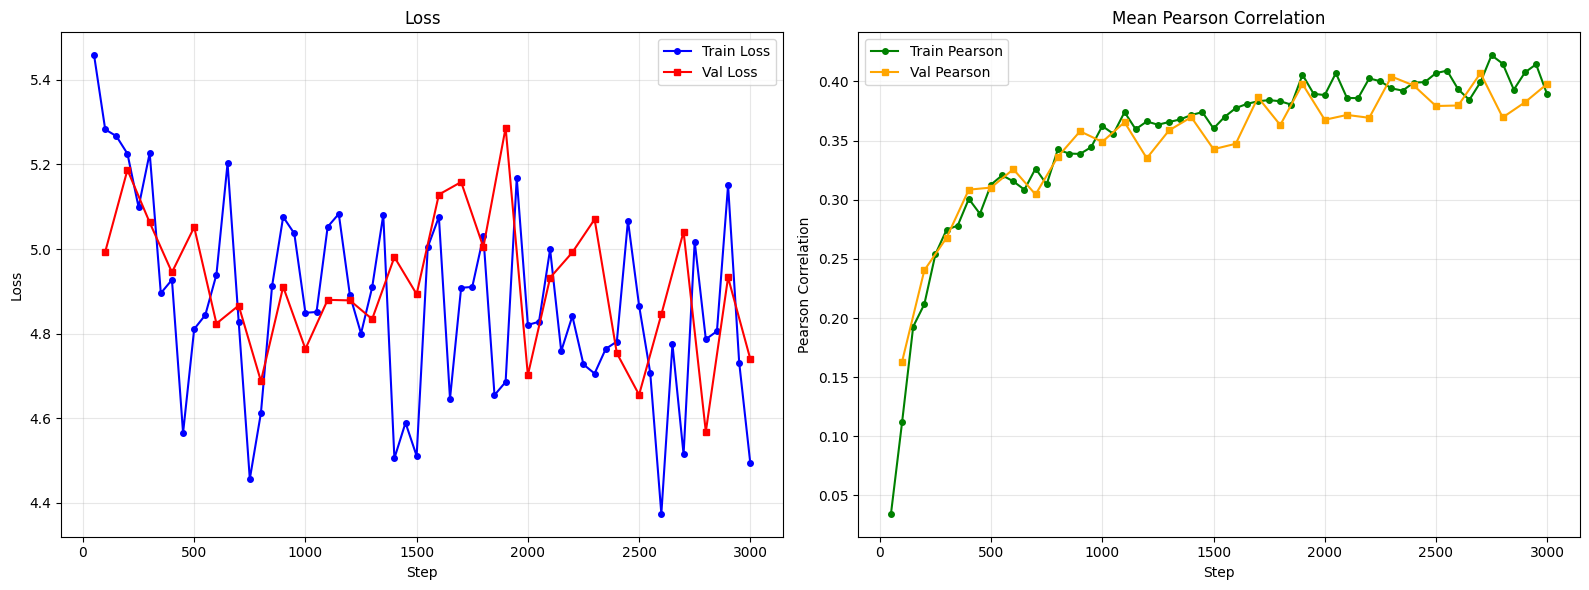

In [ ]:
# Plot training results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df_train = pd.read_csv("metrics_train.csv")
df_val = pd.read_csv("metrics_val.csv")

# Plot Loss
axes[0].plot(df_train["step"], df_train["mean_loss"], 'b-o', label='Train Loss', markersize=4, linewidth=1.5)
axes[0].plot(df_val["step"], df_val["mean_loss"], 'r-s', label='Val Loss', markersize=4, linewidth=1.5)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Pearson Correlation
axes[1].plot(df_train["step"], df_train["mean_pearson"], 'g-o', label='Train Pearson', markersize=4, linewidth=1.5)
axes[1].plot(df_val["step"], df_val["mean_pearson"], 'orange', marker='s', label='Val Pearson', markersize=4, linewidth=1.5)
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Pearson Correlation')
axes[1].set_title('Mean Pearson Correlation')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 9. 🧪 Test evaluation

Evaluate the fine-tuned model on the held-out test set to assess final performance. This provides an unbiased estimate of how well the model generalizes to unseen genomic regions.

In [31]:
# Calculate number of test steps (based on deepspeed pipeline)
num_test_samples = len(test_dataset)
num_test_steps = num_test_samples // config["batch_size"]
print(f"Running test evaluation with {num_test_steps} steps ({num_test_samples} samples)")

# Set model to eval mode
model.eval()

# Run test evaluation with progress bar
for test_batch in tqdm(test_loader, desc="Test evaluation", total=num_test_steps):        
    _ = validation_step(        
        model, 
        test_batch, 
        test_metrics,
    )
    
# Compute final test metrics
test_metrics_dict = test_metrics.compute()
print("\n" + "="*50)
print("Test Set Results")
print("="*50)
print(f"\nMetrics:")
print(f"  Mean Pearson: {test_metrics_dict['mean/pearson']:.4f}")
for track_name in bigwig_ids:    
    print(f"    {track_name}/pearson: {test_metrics_dict[f'{track_name}/pearson']:.4f}")

Running test evaluation with 312 steps (10000 samples)


Test evaluation:   0%|          | 0/312 [00:00<?, ?it/s]


Test Set Results

Metrics:
  Mean Pearson: 0.3691
    ENCSR814RGG/pearson: 0.5595
    ENCSR100LIJ_P/pearson: 0.2243
    ENCSR799DGV_P/pearson: 0.2273
    ENCSR321PWZ_P/pearson: 0.4382
    ENCSR527JGN_P/pearson: 0.4078
    ENCSR046BCI_M/pearson: 0.2326
    ENCSR682BFG/pearson: 0.4550
    ENCSR935RNW_M/pearson: 0.2374
    ENCSR410DWV/pearson: 0.3997
    ENCSR862QCH_P/pearson: 0.3448
    ENCSR527JGN_M/pearson: 0.3767
    ENCSR862QCH_M/pearson: 0.3938
    ENCSR628PLS/pearson: 0.3576
    ENCSR754DRC/pearson: 0.3627
    ENCSR487QSB/pearson: 0.4451
    ENCSR863PSM/pearson: 0.4887
    ENCSR484LTQ_M/pearson: 0.3570
    ENCSR619DQO_P/pearson: 0.4445
    ENCSR154HRN_M/pearson: 0.3726
    ENCSR154HRN_P/pearson: 0.3528
    ENCSR619DQO_M/pearson: 0.4806
    ENCSR799DGV_M/pearson: 0.2343
    ENCSR962OTG/pearson: 0.6726
    ENCSR321PWZ_M/pearson: 0.4743
    ENCSR325NFE/pearson: 0.5890
    ENCSR249ROI_M/pearson: 0.4057
    ENCSR100LIJ_M/pearson: 0.2384
    ENCSR114HGS_M/pearson: 0.2002
    ENCSR249ROI

## 📊 Test Set Results

### Performance Metrics obtained for reference

**Mean Pearson Correlation: `0.3691`**

| Track ID | Pearson Correlation |
|----------|---------------------|
| ENCSR962OTG | 0.6726 |
| ENCSR325NFE | 0.5890 |
| ENCSR814RGG | 0.5595 |
| ENCSR619DQO_M | 0.4806 |
| ENCSR863PSM | 0.4887 |
| ENCSR321PWZ_M | 0.4743 |
| ENCSR682BFG | 0.4550 |
| ENCSR487QSB | 0.4451 |
| ENCSR619DQO_P | 0.4445 |
| ENCSR321PWZ_P | 0.4382 |
| ENCSR701YIC | 0.4267 |
| ENCSR249ROI_P | 0.4191 |
| ENCSR527JGN_P | 0.4078 |
| ENCSR249ROI_M | 0.4057 |
| ENCSR410DWV | 0.3997 |
| ENCSR862QCH_M | 0.3938 |
| ENCSR527JGN_M | 0.3767 |
| ENCSR154HRN_M | 0.3726 |
| ENCSR754DRC | 0.3627 |
| ENCSR628PLS | 0.3576 |
| ENCSR484LTQ_M | 0.3570 |
| ENCSR154HRN_P | 0.3528 |
| ENCSR862QCH_P | 0.3448 |
| ENCSR484LTQ_P | 0.3212 |
| ENCSR100LIJ_M | 0.2384 |
| ENCSR935RNW_M | 0.2374 |
| ENCSR046BCI_M | 0.2326 |
| ENCSR799DGV_M | 0.2343 |
| ENCSR799DGV_P | 0.2273 |
| ENCSR100LIJ_P | 0.2243 |
| ENCSR935RNW_P | 0.2223 |
| ENCSR114HGS_M | 0.2002 |
| ENCSR046BCI_P | 0.2061 |
| ENCSR114HGS_P | 0.1824 |

### ⚙️ Hardware & Configuration

| Component | Specification |
|-----------|---------------|
| **GPU** | H100 |
| **Data Loading Workers** | 16 |
| **Sequence Length** | 32kb |
| **Batch Size** | 32 |
| **Learning Rate** | 5e-5 |
| **Training Steps** | 3000 steps |
| **Training Time** | ~15 minutes |
| **Tokens seen during Training** | ~3.15B tokens |


### 📝 Notes

> **Note:** Results may vary depending on:
> - Configuration hyperparameters
> - Hardware configuration
> - Number of tracks used (subset vs. all available functional tracks)
> - Training duration
> 
> For reference, NTv3-benchmark models on human data were trained for **20.9B tokens** before test set evaluation and achieved better performance than reported here.